   # COVID-19 em Portugal
Aproveitando a pandemia para aprender Python

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime
import scipy

plt.style.use('ggplot')
tamanho=(24,10)

### Load dos dados da DGS a partir do repositório da DSSG

In [3]:
url = 'https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv'
df = pd.read_csv(url, parse_dates=[0], index_col=[0], infer_datetime_format=True, dayfirst=True)
df.fillna(value=0);
df=df.truncate(before=pd.Timestamp('2020-03-01'))

In [4]:
df.drop('data_dados', axis=1).diff().tail(1)

,confirmados,confirmados_arsnorte,confirmados_arscentro,confirmados_arslvt,confirmados_arsalentejo,confirmados_arsalgarve,confirmados_acores,confirmados_madeira,confirmados_estrangeiro,confirmados_novos,...,obitos_50_59_f,obitos_50_59_m,obitos_60_69_f,obitos_60_69_m,obitos_70_79_f,obitos_70_79_m,obitos_80_plus_f,obitos_80_plus_m,obitos_f,obitos_m
data,,,,,,,,,,,,,,,,,,,,,
2020-05-13,219.0,59.0,6.0,153.0,0.0,1.0,0.0,0.0,NaN,-15.0,...,0.0,0.0,2.0,1.0,1.0,0.0,5.0,3.0,8.0,4.0


# Casos Confirmados

Plot do número total de casos confirmados em escala linear e em escala logarítmica

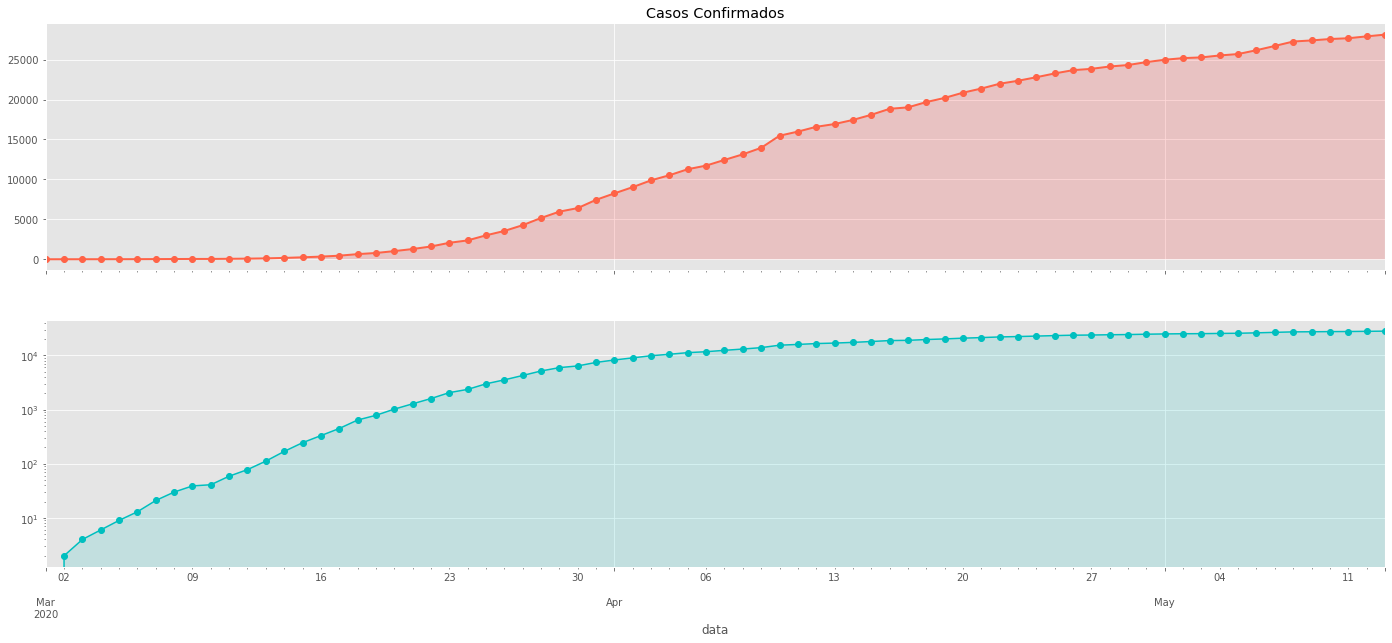

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1)
df.plot(y='confirmados',kind='line', linestyle='-',linewidth=2, marker='o',ax=ax1,figsize=tamanho,color='tomato',title='Casos Confirmados',legend=False);
ax1.fill_between(df.index, df['confirmados'], 0,
                facecolor='red', alpha=0.15, interpolate=True);
df.plot(y='confirmados',kind='line', linestyle='-',linewidth=1.5, marker='o',ax=ax2,logy=True,color='c',sharex=True,legend=False);
ax2.fill_between(df.index, df['confirmados'], 0,
                facecolor='c', alpha=0.15, interpolate=True);

## Taxa de Crescimento diário
Importa também avaliar a variação diária do aumento de número de casos.
Para isto, vou criar uma nova variável, **crescimento**, que terá em conta o aumento em relação ao dia anterior. A **Variação** será o valor de crescimento relativo ao número de casos do dia anterior.

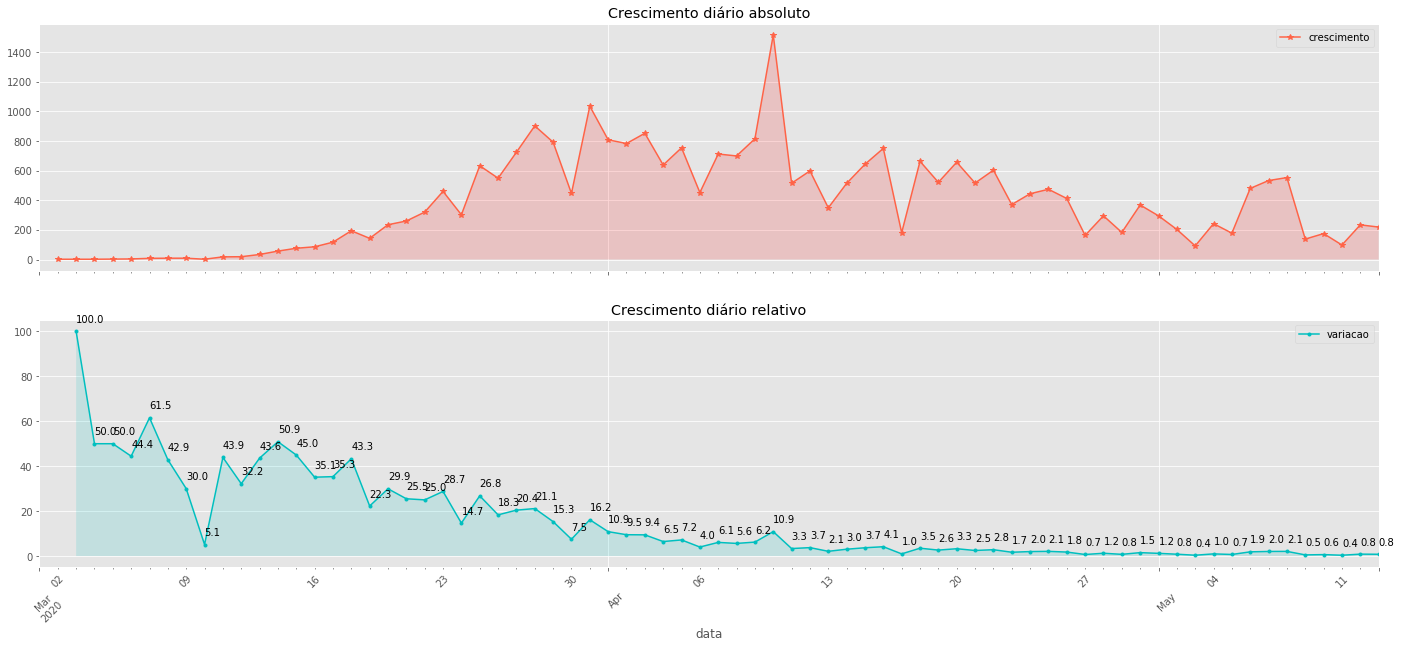

In [654]:
df['crescimento'] = df['confirmados'].diff()
df['variacao']=df['crescimento']/df['confirmados'].shift()*100

fig, (ax1, ax2) = plt.subplots(2, 1)
df.plot(y=['crescimento'],
       kind='line',figsize=tamanho,rot=45,ax=ax1,color='tomato',title='Crescimento diário absoluto',marker='*');
ax1.fill_between(df.index, df['crescimento'], 0,
                facecolor='red', alpha=0.15, interpolate=True);
df.plot(y=['variacao'],
       kind='line',figsize=tamanho,rot=45,ax=ax2,color='c',title='Crescimento diário relativo',sharex=True,marker='.');
ax2.fill_between(df.index, df['variacao'], 0,
                facecolor='c', alpha=0.15, interpolate=True);
for l in range (2,len(df.variacao)):
    plt.text(df.index[l],df.variacao[l]+4,float(round(df.variacao[l],1)), fontsize=10)


# Estimativas a longo prazo


Enquanto se verificar um comportamento exponencial, é relativamente fácil prever o crescimento do número de casos. Basta ajustar uma curva exponêncial aos dados que temos até à data de hoje e verificar as previsões. Bota.

Primeiro, apenas por uma questão de visualização definir para quantos dias faremos a previsão:

In [655]:
prazo=15

Agora uma série de operações que não devem ser de todo *best practice*. *But, who cares?*

In [656]:
df_longoprazo=df[{'confirmados'}].copy(deep=True)

In [657]:
df_dias=df_longoprazo.copy()
hoje=df_dias.index[0]
df_dias.index=(df_dias.index-hoje).days

In [658]:
dia_atual=df_dias.index[-1]

In [659]:
for x in range(prazo):
    last_date = (df_dias.index[-1])
    data = {'confirmados':None} 
    df_dias=df_dias.append(pd.DataFrame(data, index=[last_date+1])) 

*The plot thickens*. Pimbas, matemática. Ajustar uma curva exponencial aos dados atuais. A equação é ajustada a cada novo dia.

In [660]:
def exponential(x, a, b, c):
    return a * np.exp(b * x) + c

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def gompertz(x, L ,x0, k, b):
    y = L*(np.exp(-k*(np.exp(-b*x))))
    return (y)

xdata=df_dias.index.tolist()[0:dia_atual]
ydata=df_dias.confirmados.tolist()[0:dia_atual]

#Exponencial-------------------------

#popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, xdata, ydata, p0=[0.5,0.5,0.5])
#A=popt_exponential[0]
#k=popt_exponential[1]
#dados a 23/03 para ver se estamos a contrariar a exponcencial
#A_fixo=9.044422192451421
#k_fixo=0.2483378019765311
#exps=(A_fixo*np.exp(k_fixo*df_dias.index)).tolist()


#Sigmoide----------------------------
p0 = [max(ydata), np.median(xdata),0.5,min(ydata)]

popt_sig, pcov_sig = scipy.optimize.curve_fit(sigmoid, xdata, ydata,p0)
popt_sig_fixo=[ 1.38421686e+04,  2.92783796e+01,  2.41778587e-01, -4.90583543e+01]
sigs= sigmoid(df_dias.index, *popt_sig)

#Gompertz----------------------------
p0 = [max(ydata), np.median(xdata),1,min(ydata)]

popt_gomp, pcov_gomp = scipy.optimize.curve_fit(gompertz, xdata, ydata,p0, method='dogbox')
popt_gomp_fixo=[3.03167080e+04, 1.64958302e+01, 1.56617116e+01, 8.01077668e-02]
gomps= gompertz(df_dias.index, *popt_gomp)

df_dias['ajuste sig']=pd.Series(sigs)
df_dias['ajuste gomp']=pd.Series(gomps)

In [661]:
popt_sig, popt_gomp


(array([ 2.87737726e+04,  3.82779431e+01,  1.09787469e-01, -1.24166895e+03]),
 array([2.92061714e+04, 6.94033511e+01, 1.24704391e+01, 7.27590566e-02]))

Mais cenas meias improvisadas

In [662]:
for x in range(prazo):
    last_date = (df.index[-1]+timedelta(days=1+x))
    data = {'confirmados':None} 
    df_longoprazo=df_longoprazo.append(pd.DataFrame(data, index=[last_date]))

In [663]:
df_longoprazo['sigmoide']=df_dias.iloc[:,1].values
df_longoprazo['gompertz']=df_dias.iloc[:,2].values

Gráficos sobrepostos: curva real e curva teórica. Os valores apresentados são os reais até ao dia em que os há, depois disso são os previstos/estimados.

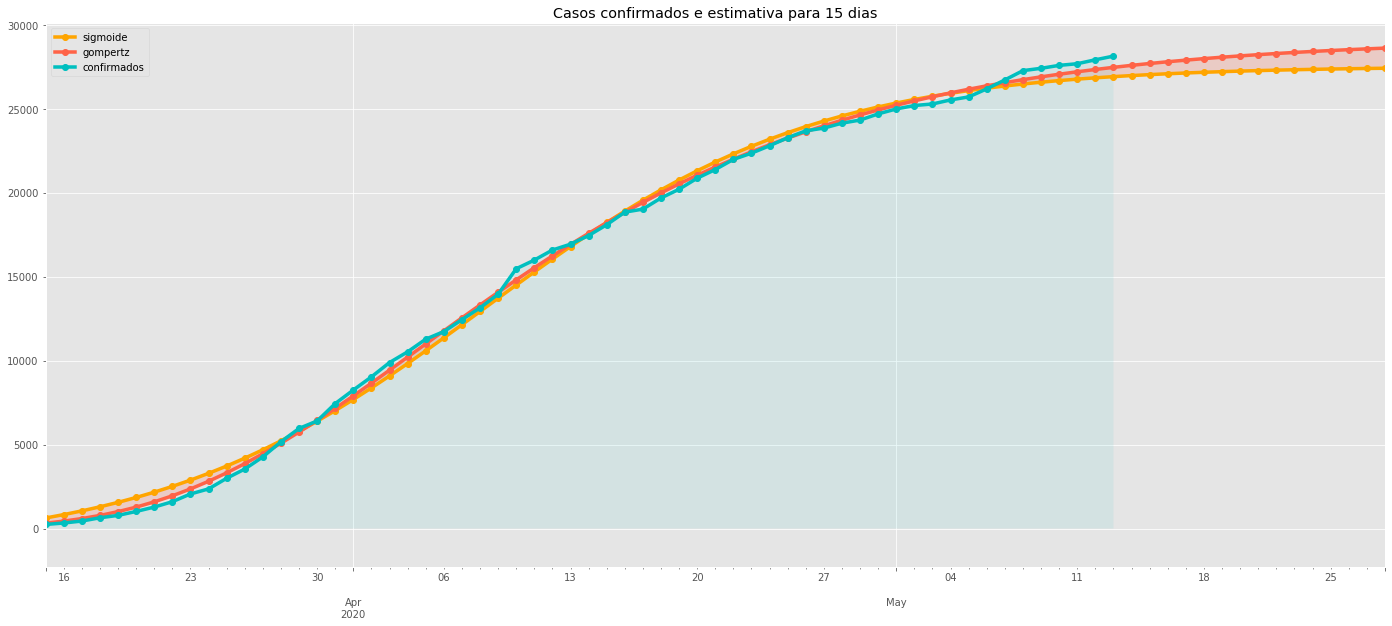

In [664]:
df_longoprazo.plot(y=['sigmoide','gompertz','confirmados'],
        kind='line', linestyle='-',linewidth=3.5,marker='o',figsize=tamanho,color=['orange','tomato','c'],title='Casos confirmados e estimativa para '+ str(prazo)+' dias',xlim=(pd.Timestamp('03-15-2020'),pd.Timestamp(df.index[-1]+timedelta(days=1+x))));
#for i in range (45,len(df_longoprazo)-(prazo)):
    #plt.text(df_longoprazo.index[i],df_longoprazo.confirmados[i]+200,df_longoprazo.confirmados[i], fontsize=8)
#for l in range (1,prazo+1):
    #plt.text(df_longoprazo.index[dia_atual+l],df_longoprazo.gompertz[dia_atual+l]+500,int(round(df_longoprazo.gompertz[dia_atual+l],0)), fontsize=11)

plt.fill_between(df_longoprazo.index, df_longoprazo['gompertz'], df_longoprazo['sigmoide'],
                facecolor='tomato', alpha=0.2, interpolate=True);
plt.fill_between(df.index, df['confirmados'], 0,
                facecolor='c', alpha=0.08, interpolate=True);

    

## Internados e UCI

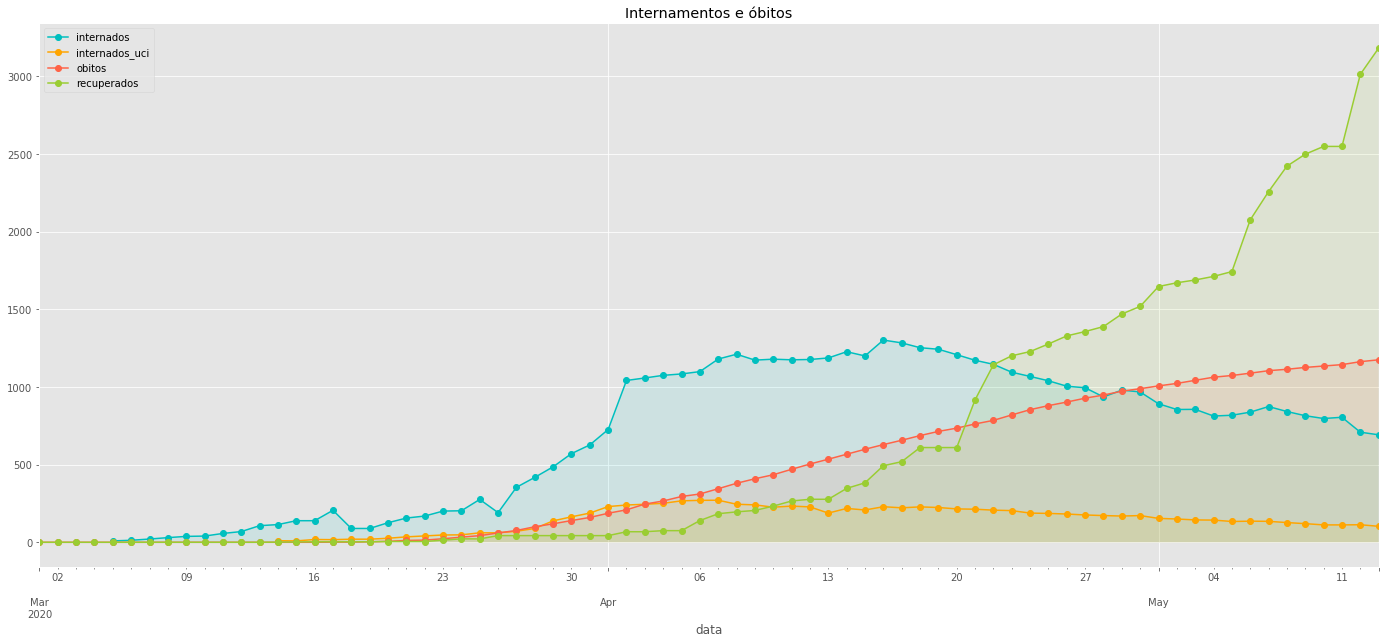

In [665]:
df.plot(y=['internados','internados_uci','obitos','recuperados'],
        kind='line', linestyle='-',linewidth=1.5,marker='o',figsize=tamanho,color=['c','orange','tomato','yellowgreen'],title='Internamentos e óbitos');

plt.fill_between(df.index, df['internados'], 0,
                facecolor='c', alpha=0.1, interpolate=True);
plt.fill_between(df.index, df['internados_uci'], 0,
                facecolor='gold', alpha=0.1, interpolate=True);
plt.fill_between(df.index, df['obitos'], 0,
                facecolor='tomato', alpha=0.1, interpolate=True);
plt.fill_between(df.index, df['recuperados'], 0,
                facecolor='yellowgreen', alpha=0.1, interpolate=True);

## Casos ativos
Porque o número total de casos confirmados é cumulativo, convém também saber o número de casos ativos.

Para isso, adicionar uma nova coluna a adicionar à *dataframe*: **casos_ativos**

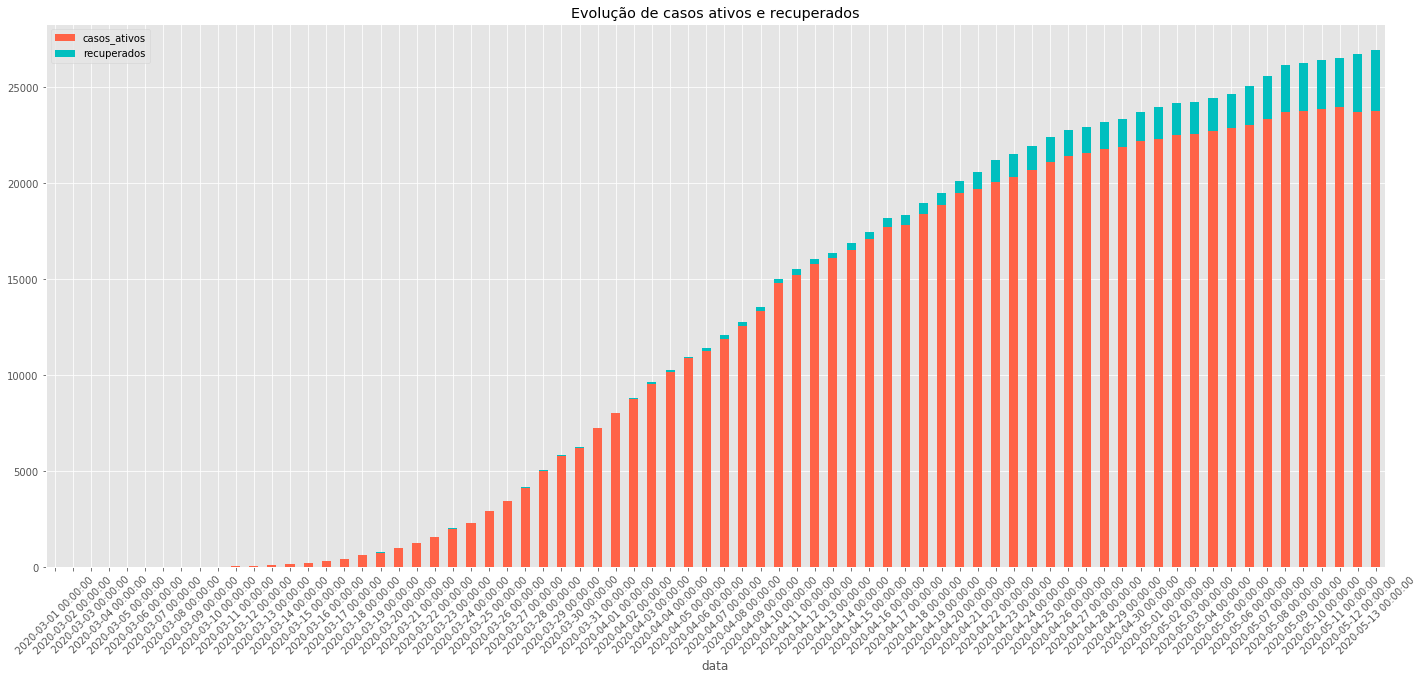

In [666]:
df['casos_ativos'] = df['confirmados'] - df['recuperados'] - df['obitos']
df.plot(y=['casos_ativos','recuperados'],
       kind='bar',figsize=tamanho,stacked=True,rot=45,color=['tomato','c'],title='Evolução de casos ativos e recuperados');

### Percentagem de internados

In [667]:
perc_internados = round(df.internados.tail(1).values[0]/df.casos_ativos.tail(1).values[0]*100,2)
perc_uci = round(df.internados_uci.tail(1).values[0]/df.casos_ativos.tail(1).values[0]*100,2)

print('Percentagem de internados: '+ str(perc_internados)+'%''\nPercentagem em UCI: '+ str(perc_uci)+'%')

Percentagem de internados: 2.91%
Percentagem em UCI: 0.43%


### Casos Confirmados por região

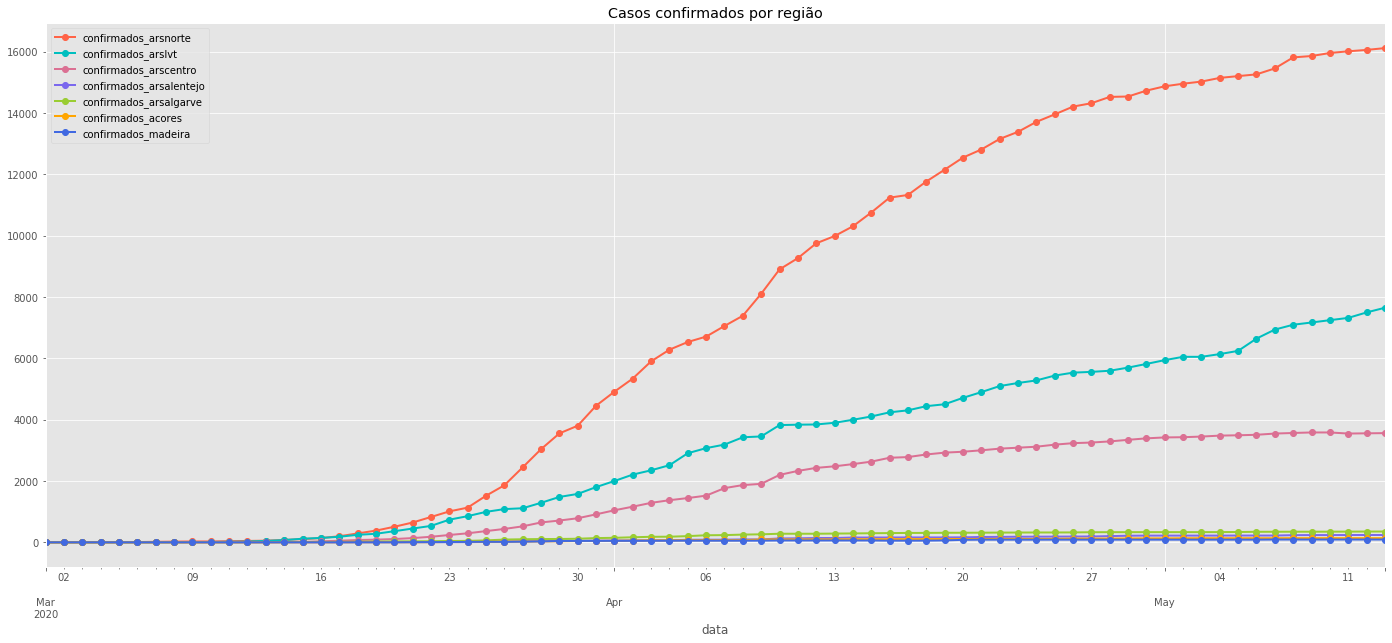

In [668]:
df.plot(y=['confirmados_arsnorte','confirmados_arslvt','confirmados_arscentro','confirmados_arsalentejo','confirmados_arsalgarve','confirmados_acores','confirmados_madeira'],
        kind='line', linestyle='-',linewidth=2,marker='o',figsize=tamanho,color=['tomato','c','palevioletred','mediumslateblue','yellowgreen','orange','royalblue'],title='Casos confirmados por região');

## Casos na Madeira
Segundo o boletim da DGS e não do IASAUDE...

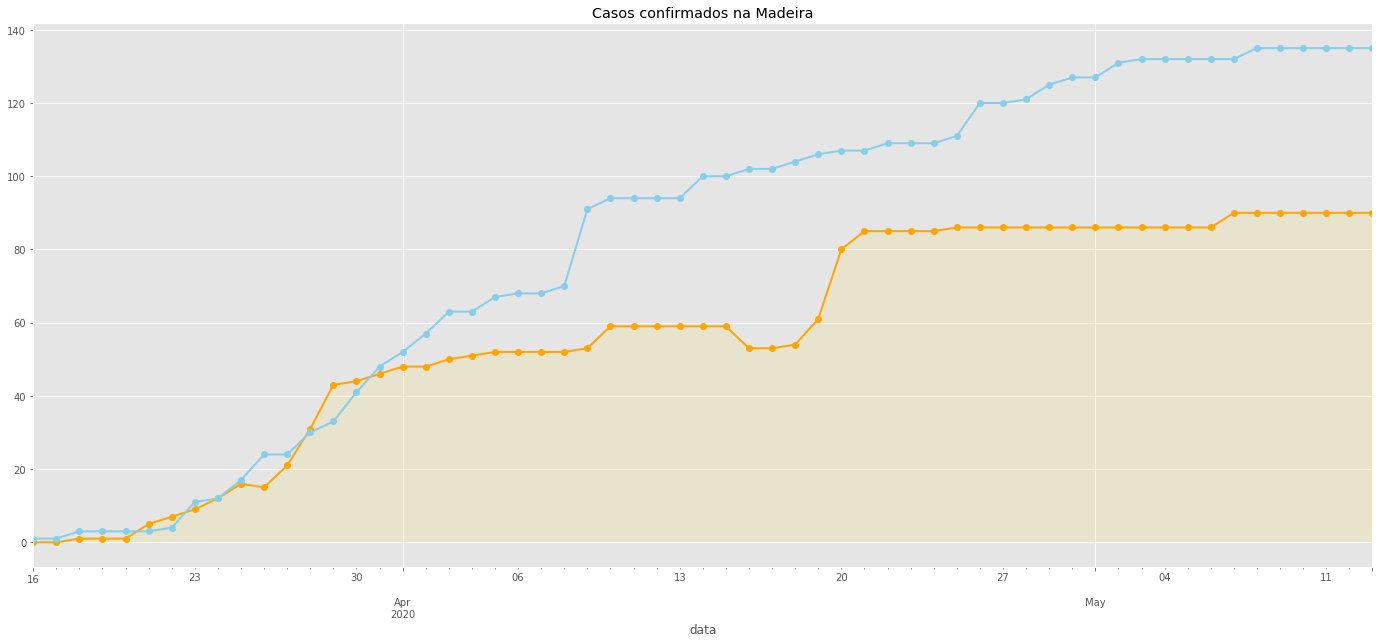

In [669]:
df.truncate(before=pd.Timestamp('2020-03-16')).plot(y=['confirmados_madeira','confirmados_acores'],
        kind='line', linestyle='-',linewidth=2,marker='o',figsize=tamanho,color=['orange','skyblue'],grid=True,legend=False,title='Casos confirmados na Madeira');
plt.fill_between(df.index, df['confirmados_madeira'], 0,
                facecolor='gold', alpha=0.1, interpolate=True);

## Confirmados por escalão etário

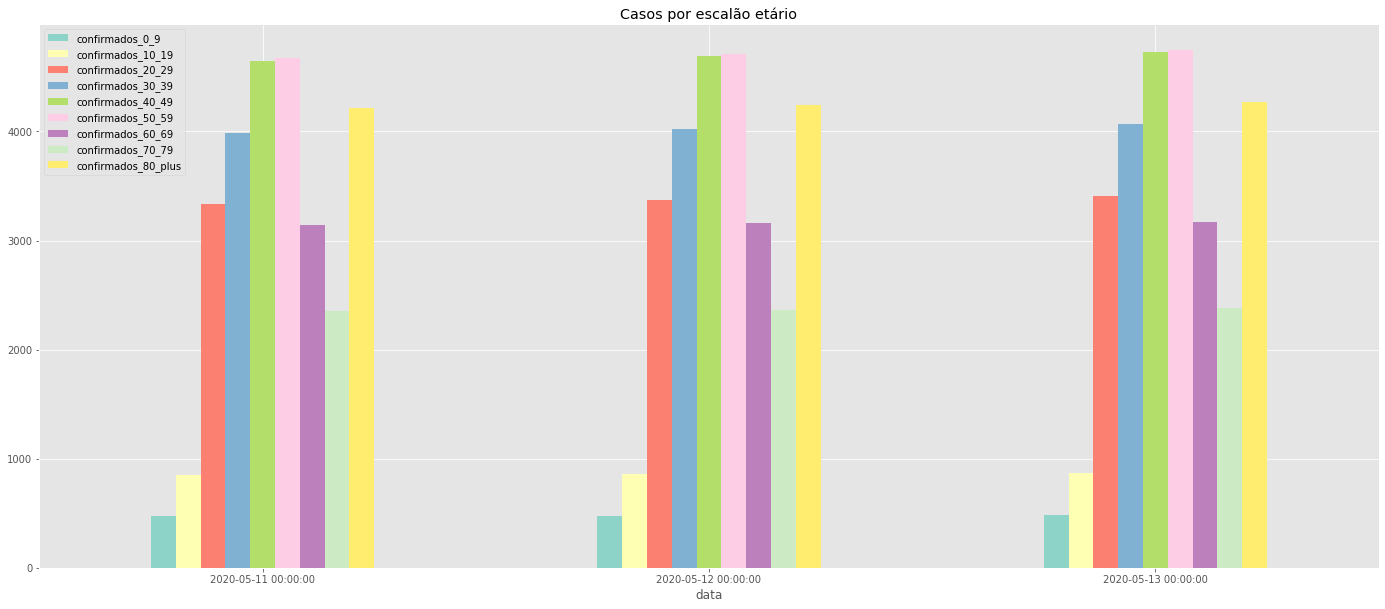

In [670]:
df['confirmados_0_9']=df['confirmados_0_9_f']+df['confirmados_0_9_m']
df['confirmados_10_19']=df['confirmados_10_19_f']+df['confirmados_10_19_m']
df['confirmados_20_29']=df['confirmados_20_29_f']+df['confirmados_20_29_m']
df['confirmados_30_39']=df['confirmados_30_39_f']+df['confirmados_30_39_m']
df['confirmados_40_49']=df['confirmados_40_49_f']+df['confirmados_40_49_m']
df['confirmados_50_59']=df['confirmados_50_59_f']+df['confirmados_50_59_m']
df['confirmados_60_69']=df['confirmados_60_69_f']+df['confirmados_60_69_m']
df['confirmados_70_79']=df['confirmados_70_79_f']+df['confirmados_70_79_m']
df['confirmados_80_plus']=df['confirmados_80_plus_f']+df['confirmados_80_plus_m']
      


df.tail(3).plot(y=['confirmados_0_9',
       'confirmados_10_19',
       'confirmados_20_29',
       'confirmados_30_39',
       'confirmados_40_49',
       'confirmados_50_59',
       'confirmados_60_69',
       'confirmados_70_79', 
       'confirmados_80_plus'],
       kind='bar',figsize=tamanho,colormap='Set3',rot=0,grid=True,title='Casos por escalão etário');

## Casos suspeitos e a aguardar laboratório

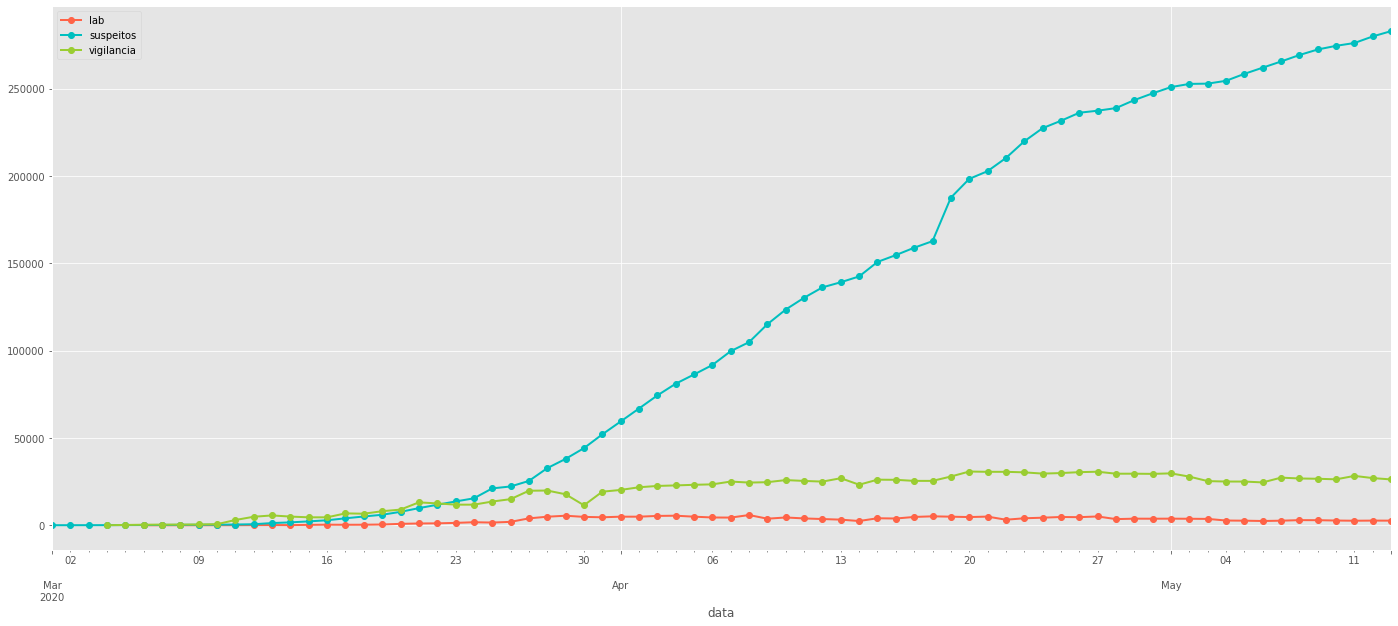

In [671]:
df.plot(y=['lab','suspeitos','vigilancia'],
        kind='line', linestyle='-',linewidth=2,marker='o',figsize=tamanho,color=['tomato','c','yellowgreen','orange']);

# Dados de Itália

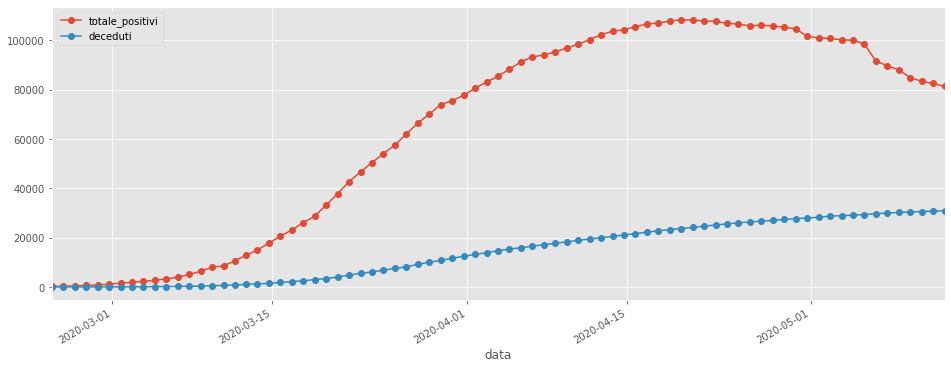

In [672]:
url_italia='https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv'
df_italia = pd.read_csv(url_italia, parse_dates=[0], index_col=[0], infer_datetime_format=True)
df_italia.fillna(value=0);
#dia0=pd.Timestamp('2020-01-30') # dia 0 de casos
#df_italia.index=(df_italia.index-dia0).days
df_italia.plot(y=['totale_positivi','deceduti'],figsize=(16,6),marker='o');

In [673]:
df_italia.tail(2)

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
data,,,,,,,,,,,,,,,
2020-05-11 17:00:00,ITA,13539,999,14538,67950,82488,-836,744,106587,30739,219814,2606652,1702283.0,NaN,NaN
2020-05-12 17:00:00,ITA,12865,952,13817,67449,81266,-1222,1402,109039,30911,221216,2673655,1741903.0,dc-IT-0027,dc-EN-0027
